# Module C Research Training Day 
## Part I: On Sliding Block Maxima and GEV Parameter Estimation

First, we require some installations to be done:

In [31]:
!pip install xtremes==0.2.6
import numpy as np
import matplotlib.pyplot as plt
import xtremes as xx
import xtremes.HigherOrderStatistics as hos
import xtremes.miscellaneous as misc
import xtremes.bootstrap as bst


## Demonstration on simulated data
Let us look at some simulated time seires first. We will draw $n=2500$ random variables from a $\mathrm{GPD}(\alpha)$-distribution [generalized pareto distribution] with $\alpha=5$. From this setiing, we want to simulate $rep=100$ realizations.

In [32]:
# set the parameters
n = 2500
a = 5
rep = 100

Some exemplary time series models (IID, ARMAX, AR) are implemented in the class `hos.TimeSeries()`

In [33]:
TS = hos.TimeSeries(n=n, distr='GPD', correlation='IID', modelparams=[1/a])

We will draw 10 realizations. They will be written to `TS.values` and each is a `numpy.array`.

In [34]:
TS.simulate(rep=rep)
TS.values[0]

array([0.86271504, 1.42774685, 1.01395464, ..., 1.46982318, 0.21724977,
       1.21200005])

Taking a look at the first 100 values of the first two realizations:

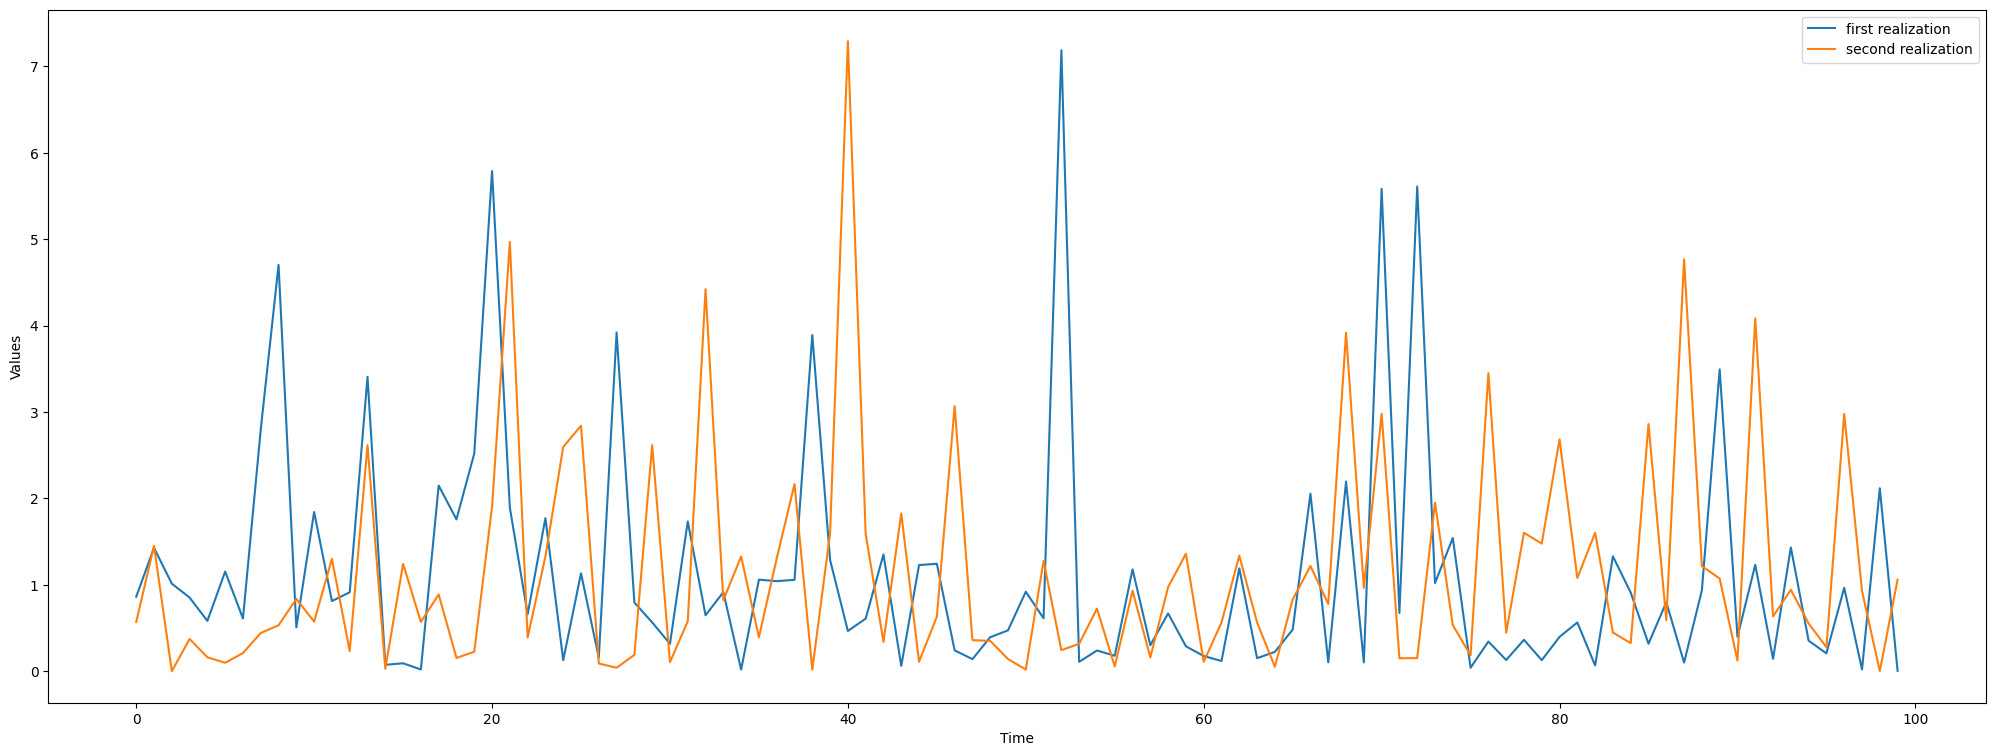

In [35]:
fig = plt.figure(figsize=(25,9))
plt.plot(TS.values[0][:100], label='first realization')
plt.plot(TS.values[1][:100], label='second realization')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

Plotting the full timeseries is also directly implemented in the `TS` class.

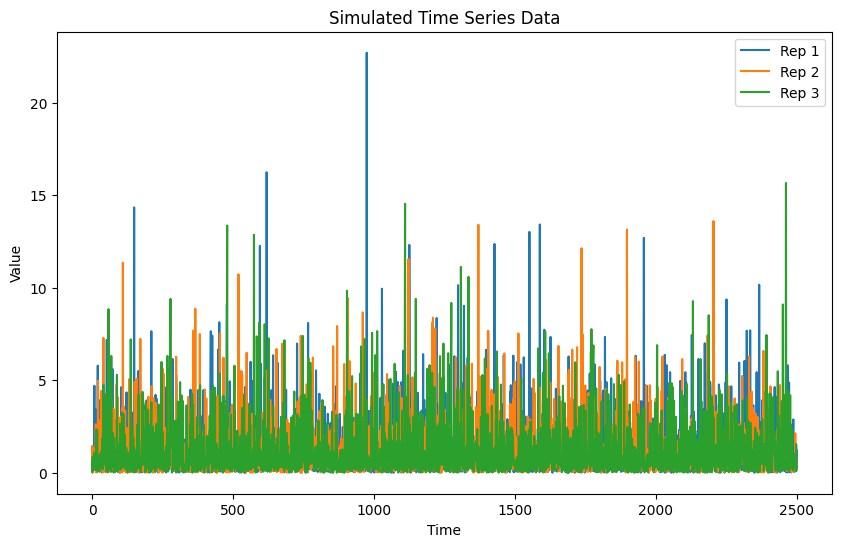

Signature: TS.plot(rep=1, filename=None)
Docstring:
Plot the simulated time series data.

This method generates a plot showing the simulated time series data. The user can choose to display 
data from specific repetitions or all repetitions.

Parameters
----------
rep : int or list, optional
    The repetition number(s) to plot. If 0, all repetitions are plotted. If a list is provided, 
    only the specified repetitions are plotted. Default is 1.
filename : str, optional
    The name of the PNG file to save the plot. If None, the plot is displayed but not saved. Default is None.
File:      ~/Documents/PhD/software/xtremes/src/xtremes/HigherOrderStatistics.py
Type:      method

In [36]:
?TS.plot
TS.plot([1,2,3])

Being interested in annual / monthly maxima, we need to define a block size, which in practice corresponds to the length of month / year / season. For illustratory purposes, we choose $\mathrm{bs}=30$. Let us take a look at disjoint blocks (`stride='DBM'`) fist.

In [37]:
bs=30

In [38]:
TS.get_blockmaxima(block_size=bs, stride='DBM')
TS.blockmaxima[0]

array([ 5.78851649,  7.18660489,  5.61028005,  4.62598824, 14.34659934,
        5.50057453,  3.91070209,  7.64634761,  4.61320012,  6.14541135,
        3.03265759,  4.49152849,  4.47909558,  4.4705813 ,  7.64793319,
        9.10407626,  4.93995592,  4.06190684,  5.99817823, 12.26393851,
       16.2452494 ,  6.35235091,  4.47796541,  2.4870186 ,  6.98238764,
        8.09692555,  5.5319424 ,  3.56984324,  4.67818806,  3.18571002,
        5.98750906,  5.36028619, 22.70586333,  4.24289936,  9.94985541,
        5.46433368,  6.59800686, 12.3182442 ,  4.32033671,  6.41185115,
        8.36329605,  5.2048477 ,  6.29352982, 10.13978089,  6.22249082,
        4.37594949,  7.65410455, 12.36838135,  6.35341097,  6.33172635,
        5.98534771, 13.01898546, 13.4206333 ,  7.72985355,  7.34220095,
        4.50385051,  6.28509919,  3.43975636,  5.3662025 ,  5.86122865,
        7.34211909,  5.10739629,  4.29932451,  4.40305134,  6.321978  ,
       12.69558757,  3.82874765,  6.37013019,  5.43762719,  4.96

We see that we successfully extracted the block maxima of each realization. Let us plot the first time series together with its maxima.

In [39]:
vals = TS.values[0]
maxima = TS.blockmaxima[0]
max_idx = np.where(np.in1d(vals, maxima))[0] # find indices of maxima in timeseries

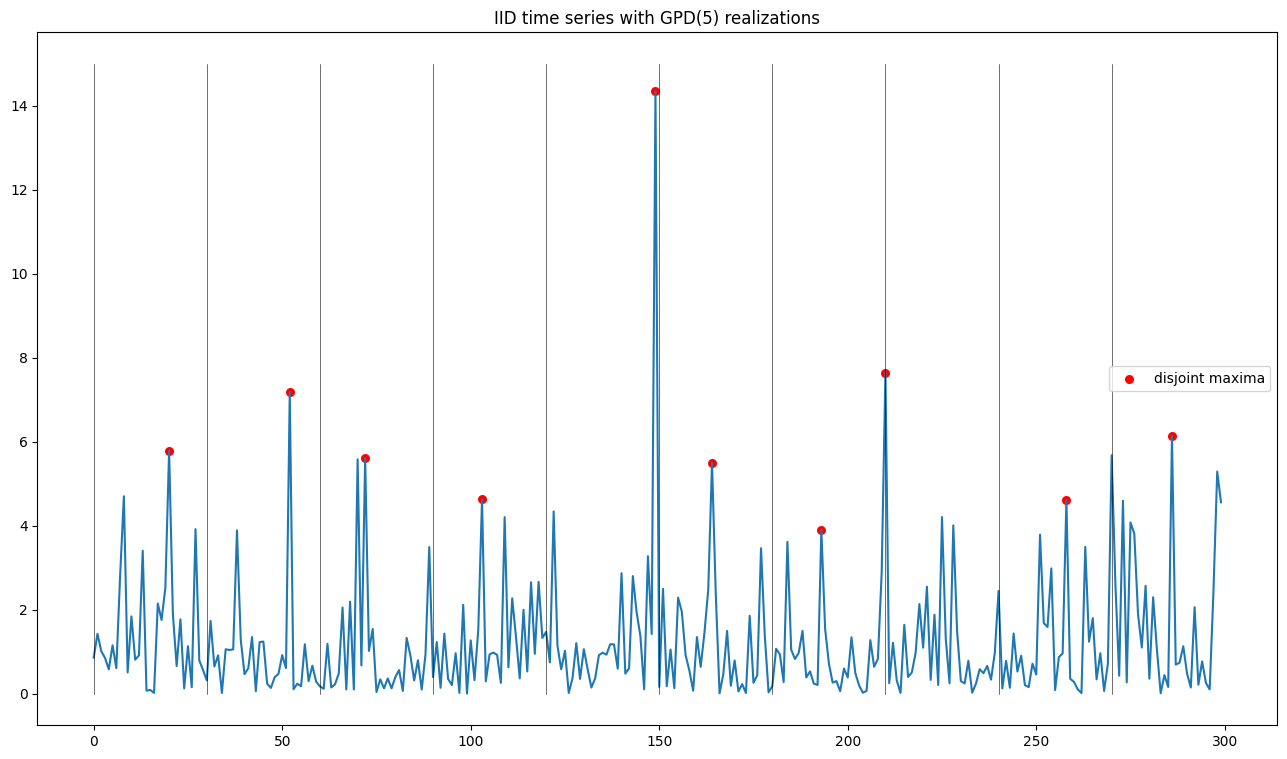

In [40]:
vals = TS.values[0]
maxima = TS.blockmaxima[0]
max_idx = np.where(np.in1d(vals, maxima))[0] # find indices of maxima in timeseries

plotlim = 300
fig = plt.figure(figsize=(16,9))
plt.tight_layout()
plt.title(f'IID time series with GPD({a}) realizations')
plt.plot(vals[:plotlim])
plt.scatter(max_idx[max_idx<plotlim], maxima[max_idx<plotlim], c='r',s=30, label='disjoint maxima')
for k in range((n+bs)//bs):
    if k < plotlim //bs:
        plt.plot([bs*k,bs*k],[0,np.ceil(max(vals[:plotlim]))], c='k', lw=0.4)
plt.legend()
plt.savefig('Blockmaxima_disj.pdf')
plt.show()

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    Task: Recreate and save the above plot using `TS.plot_with_blockmaxima`. You can get help how to use the function via `?TS.plot_with_blockmaxima`
</div>

Based on this sample, we want to perform parameter estimation. There are two common methods of estimating the parameters, either via Probability Weighted Moments (PWM) or via Maximum Likelihood. Both are pre-implemented in the package at hand, but contained in a different class, `hos.HighOrderStats`, which directly inherits from the `hos.TimeSeries` class. This class is a bit more general, as it not only deals with maxima, but more high order statistics, too. But we will deal with that later!. We will start with PWM estimators:

In [41]:
TS.get_HOS(orderstats=1, block_size=bs, stride='DBM') # just the maxima
HOS = hos.HighOrderStats(TS)
HOS.get_PWM_estimation()
HOS.PWM_estimators.statistics

{'gamma_mean': 0.1950890963267545,
 'gamma_variance': 0.008737474547022919,
 'gamma_bias': 0.00493564389870756,
 'gamma_mse': 0.008761835127717768,
 'mu_mean': 4.940365809933592,
 'mu_variance': 0.04586355676972897,
 'sigma_mean': 1.9556481547329434,
 'sigma_variance': 0.039395083230868454}

It works similarly for Maximum Likelihood estimation. As the theory the package is developed for focuses on the Frechet case, we have an option to maximize the Frechet Likelihood instead.

In [42]:
help(HOS.get_ML_estimation)

Help on method get_ML_estimation in module xtremes.HigherOrderStatistics:

get_ML_estimation(initParams='auto', r=None, FrechetOrGEV='Frechet') method of xtremes.HigherOrderStatistics.HighOrderStats instance
    Calculate the Maximum Likelihood (ML) estimators.

    Parameters
    ----------
    initParams : str or array-like, optional
        Method for initializing parameters. Default is 'auto', which uses automatic parameter initialization.

    r : int, optional
        Number of order statistics to calculate the log-likelihood on. If not specified, use all provided.

    FrechetOrGEV : str, optional
        Whether to fit the Frechet or GEV distribution.

    Notes
    -----
    This function performs maximum likelihood estimation based on either the Frechet or GEV distribution.



<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    Task: Create the Frechet and the GEV Maximum Likelihood estimators using `HOS.get_ML_estimation`.
</div>

Notice that the Frechet fit is worse than the GEV fit, as it, being a 2-parametric distribution, has less flexibility than the 3-parametric GEV.

## Towards Sliding Block Maxima
Extracting sliding block maxima instead of disjoint ones is as easy as changing `TS.get_blockmaxima(block_size=bs, stride='DBM')` to `TS.get_blockmaxima(block_size=bs, stride='SBM')`.

In [43]:
TS.get_blockmaxima(block_size=bs, stride='SBM')
maxima = TS.blockmaxima[0]
maxima.shape

(2471,)

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    Task: Plot the sliding block maxima, either by hand or by using the utilities introduced above.
</div>

Maximum Likelihood estimation works the same!

In [44]:
TS.get_HOS(orderstats=1, block_size=bs, stride='SBM') # just the maxima
HOS = hos.HighOrderStats(TS)
HOS.get_ML_estimation(r=1, FrechetOrGEV='GEV')
HOS.ML_estimators.statistics

{'gamma_mean': 0.1987491909116404,
 'gamma_variance': 0.006711384848277532,
 'gamma_bias': 0.0012571104334711215,
 'gamma_mse': 0.006712965174919474,
 'mu_mean': 4.950581887321493,
 'mu_variance': 0.04450383115174922,
 'sigma_mean': 1.942354245414025,
 'sigma_variance': 0.028553820967005452}

Notice that our mean squared error is smaller than it was in the DBM fit!

## Incooperating the Second Largest Order Statistic (Top-Two)
We want to exploit the information contained in the second largest order statistic of each block, too. Luckily, this will also work in a few clicks.

In [45]:
TS.get_HOS(orderstats=2, block_size=bs, stride='SBM')

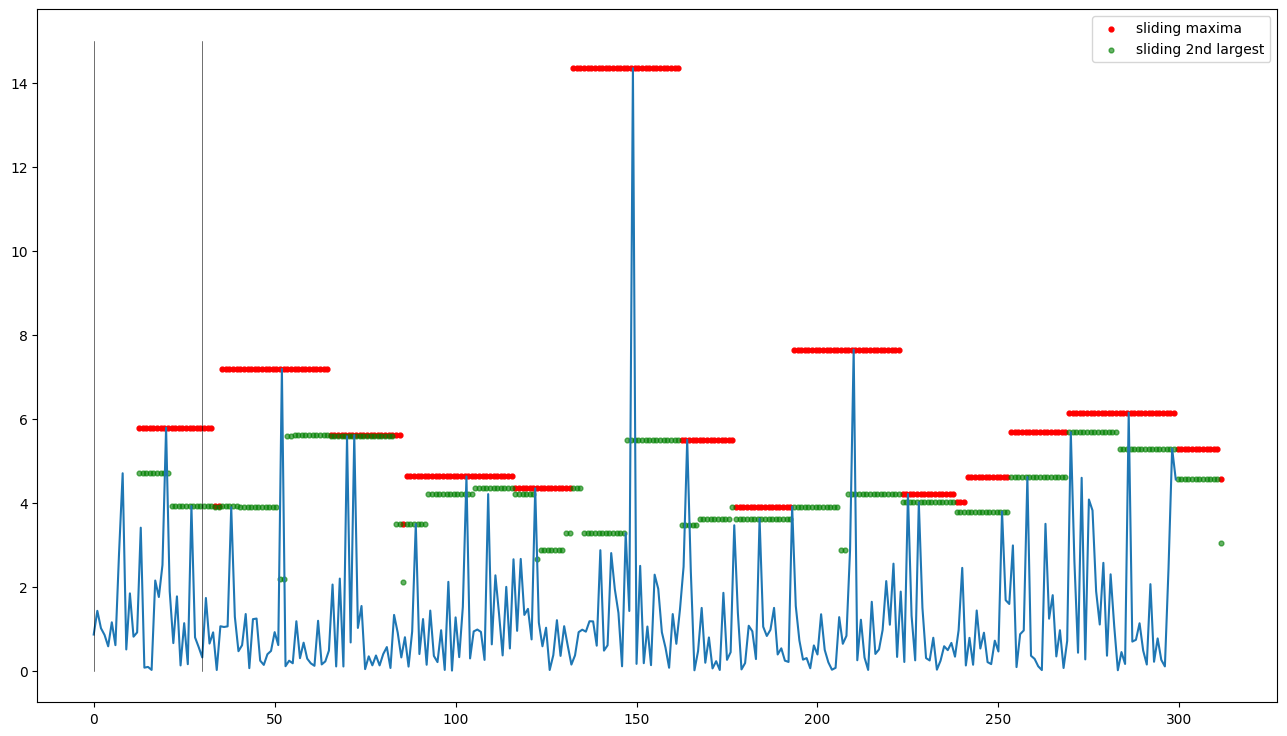

In [46]:
two, mx = TS.high_order_stats[0].T # 2nd largest, maximum

fig = plt.figure()
fig.set_size_inches((16,9))
plt.tight_layout()
plt.plot(vals[:plotlim])
plt.scatter(np.arange(len(mx))[:plotlim]+12.5, mx[:plotlim], c='r',s=12, alpha=1, label='sliding maxima')
plt.scatter(np.arange(len(two))[:plotlim]+12.5, two[:plotlim], c='g',s=12, alpha=0.6, label='sliding 2nd largest')
plt.plot([0,0],[0,np.ceil(max(mx[:plotlim]))], c='k', lw=0.4)
plt.plot([bs,bs],[0,np.ceil(max(mx[:plotlim]))], c='k', lw=0.4)
plt.legend()
plt.show()

In [47]:
HOS = hos.HighOrderStats(TS)
HOS.get_ML_estimation(r=2, FrechetOrGEV='GEV')
HOS.ML_estimators.statistics

{'gamma_mean': 0.2059789120790934,
 'gamma_variance': 0.005229267555685446,
 'gamma_bias': 0.00600903273359881,
 'gamma_mse': 0.005265376030078908,
 'mu_mean': 4.899971649903965,
 'mu_variance': 0.037205331307308784,
 'sigma_mean': 1.9384981798855159,
 'sigma_variance': 0.024286805155331204}

The MSE (especially for the shape parameter $\gamma$) still got smaller!

# Real Data Example
Just as an example, we will take daily precipitation data from Hohenpeißenberg. Let's take a look at these data.

In [48]:
# probably you have to install the "wetterdienst" module
!python -c "import wetterdienst" 2>/dev/null || pip install wetterdienst 

In [49]:
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationResolution

request = DwdObservationRequest(
    parameter="kl",
    resolution=DwdObservationResolution.DAILY,  # Daily resolution
    start_date="1879-01-01",  # Start from 1879 (Hohenpeißenberg)
    end_date="2023-12-31"  # End in 2023
)
stations = request.all().df

# Fetch data for the  station (station ID: 00558)
df = request.filter_by_station_id(station_id=[2290]).values.all().df
precip = np.array(df['value'])[df['parameter']=='precipitation_height']

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    Task: Vizualize `precip` in a scatter plot. Optinally, decrease the xrange to see individual yearly patterns.
</div>

Extracting block maxima from real data is conveniently done by `hos.extract_BM(precip, block_size=bs, stride='DBM')`. We set `return_indices=True` for plotting later on.

In [50]:
bs = 365
precip_max_idx, precip_max = hos.extract_BM(precip, block_size=bs, stride='DBM', return_indices=True)

In [51]:
len(precip_max_idx), len(precip_max)

(145, 145)

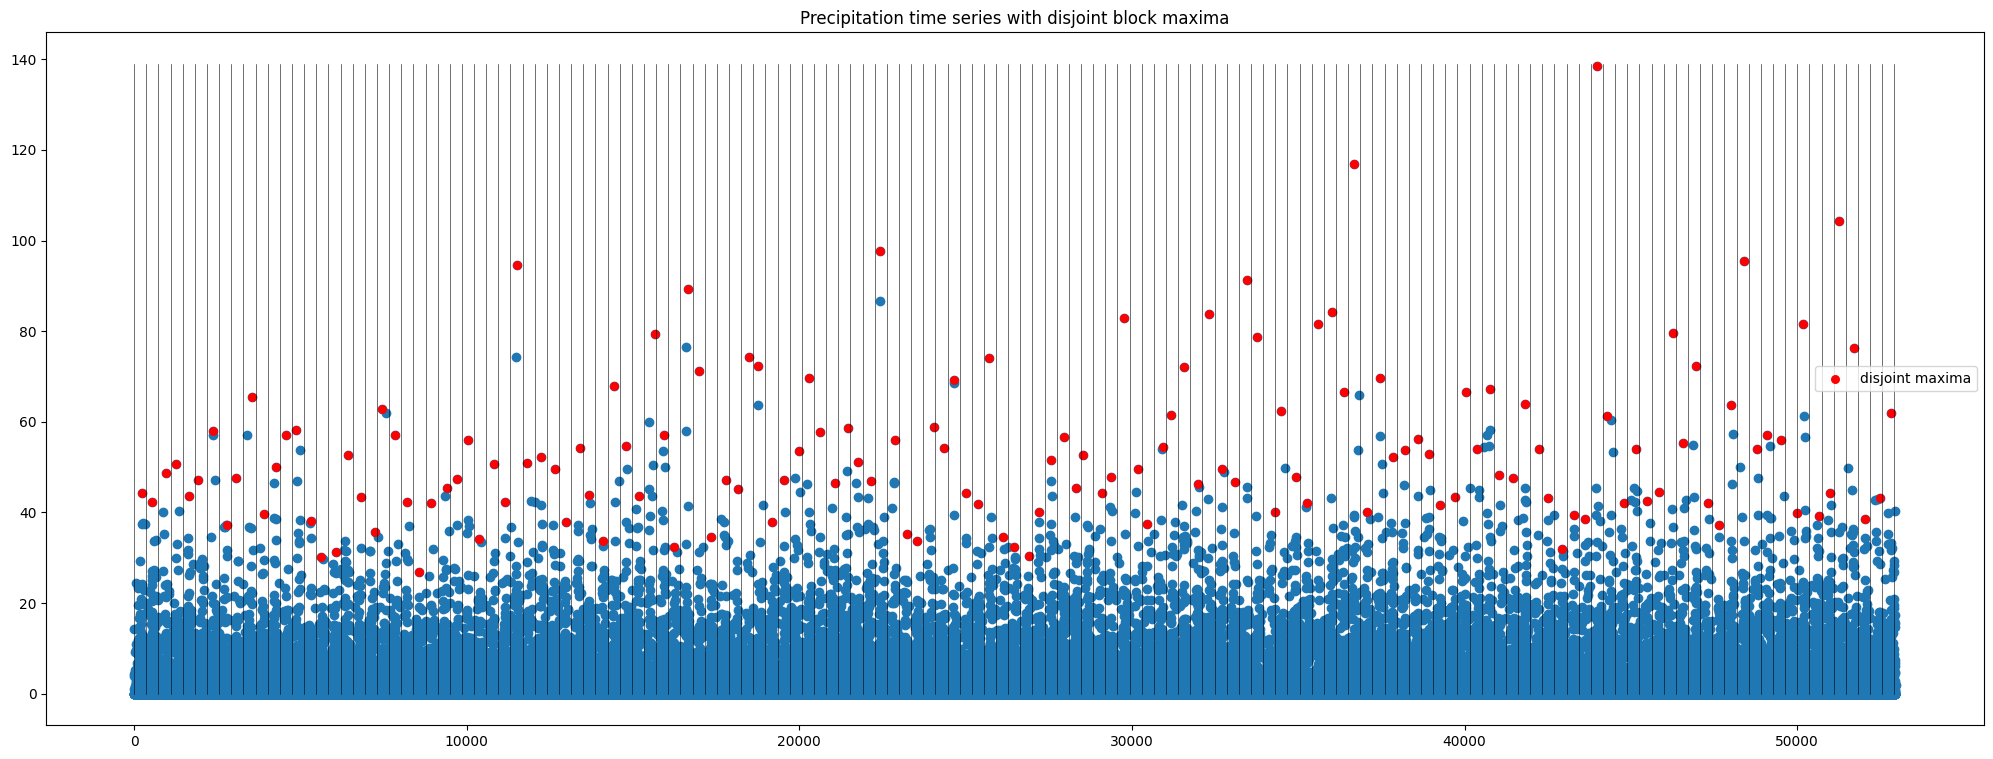

In [52]:
fig = plt.figure(figsize=(25,9))
plt.tight_layout()
plt.title(f'Precipitation time series with disjoint block maxima')
plt.scatter(np.arange(len(precip)), precip)
plt.scatter(precip_max_idx, precip_max, c='r',s=30, label='disjoint maxima')
for k in range((len(precip)+bs)//bs):
    plt.plot([bs*k,bs*k],[0,np.ceil(max(precip_max))], c='k', lw=0.4)
plt.legend()
plt.show()

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    Task: Modify the code from the cell above to vizualize the annual maxima of 10 consecutive years.
</div>

To deal with real data, the `hos.Data` class is useful. Apart from extracting block maxima, parameter estimation works as before.

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    Task: initialize a class `PREC = hos.Data(precip)` and extract the blockmaxima
</div>

array([ 44.2,  42.3,  48.7,  50.8,  43.7,  47.1,  58. ,  37.3,  47.6,
        65.4,  39.6,  50.1,  57. ,  58.1,  38.2,  30.1,  31.3,  52.6,
        43.5,  35.7,  62.8,  57.2,  42.4,  26.9,  42.2,  45.3,  47.3,
        55.9,  34.1,  50.6,  42.3,  94.5,  50.9,  52.2,  49.7,  37.9,
        54.2,  43.8,  33.8,  67.8,  54.7,  43.6,  79.4,  57.2,  32.3,
        89.3,  71.3,  34.7,  47.1,  45.2,  74.2,  72.3,  38. ,  47.1,
        53.6,  69.6,  57.8,  46.5,  58.7,  51.1,  47. ,  97.7,  55.9,
        35.2,  33.7,  58.8,  54.2,  69.2,  44.3,  41.8,  74. ,  34.6,
        32.4,  30.3,  40.1,  51.6,  56.6,  45.4,  52.6,  44.4,  47.9,
        82.9,  49.5,  37.4,  54.5,  61.4,  72.2,  46.2,  83.7,  49.6,
        46.7,  91.2,  78.7,  40.1,  62.4,  47.8,  42. ,  81.6,  84.3,
        66.5, 116.8,  40.1,  69.7,  52.2,  53.7,  56.3,  53. ,  41.7,
        43.5,  66.5,  53.9,  67.2,  48.2,  47.5,  63.9,  54.1,  43.1,
        31.9,  39.4,  38.6, 138.5,  61.3,  42.2,  53.9,  42.6,  44.5,
        79.5,  55.3,

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    Task: Perform a Frechet and GEV ML estimation. Save the results in the variables `frech_param` and `gev_param`.
</div>

## Comparing this to SBM
We will compare the DBM results now to SBM.

In [54]:
precip.shape

(52960,)

In [55]:
PREC_sl = hos.Data(precip)
PREC_sl.get_blockmaxima(block_size=365, stride='SBM')
PREC_sl.get_ML_estimation(FrechetOrGEV='GEV')
PREC_sl.ML_estimators.values

array([ 0.10980163, 45.80904173, 12.07192891])

In [56]:
len(PREC_sl.blockmaxima), len(precip)-365

(52596, 52595)

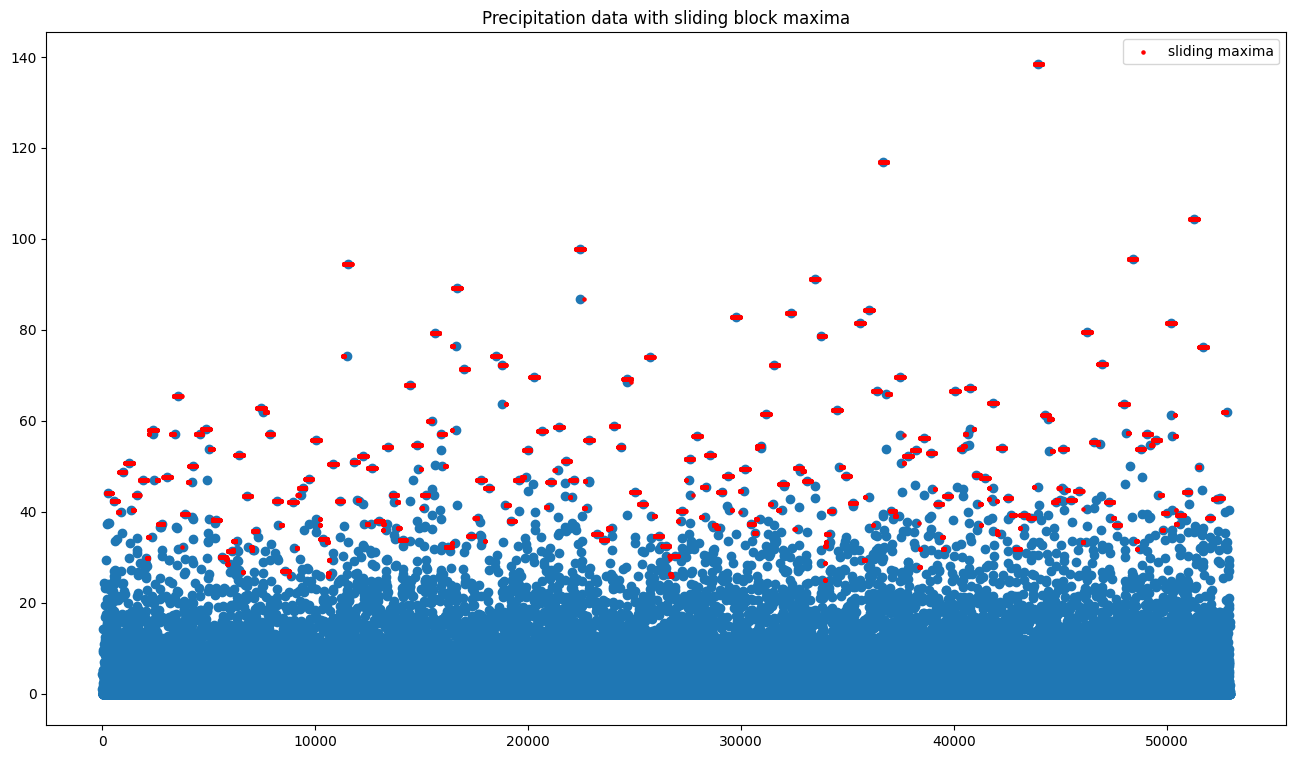

In [57]:
fig = plt.figure(figsize=(16,9))
plt.tight_layout()
plt.title(f'Precipitation data with sliding block maxima')
plt.scatter(np.arange(len(precip)), precip)
plt.scatter(np.arange(len(PREC_sl.blockmaxima))+bs/2, PREC_sl.blockmaxima, c='r',s=5, label='sliding maxima')
plt.legend()
plt.show()

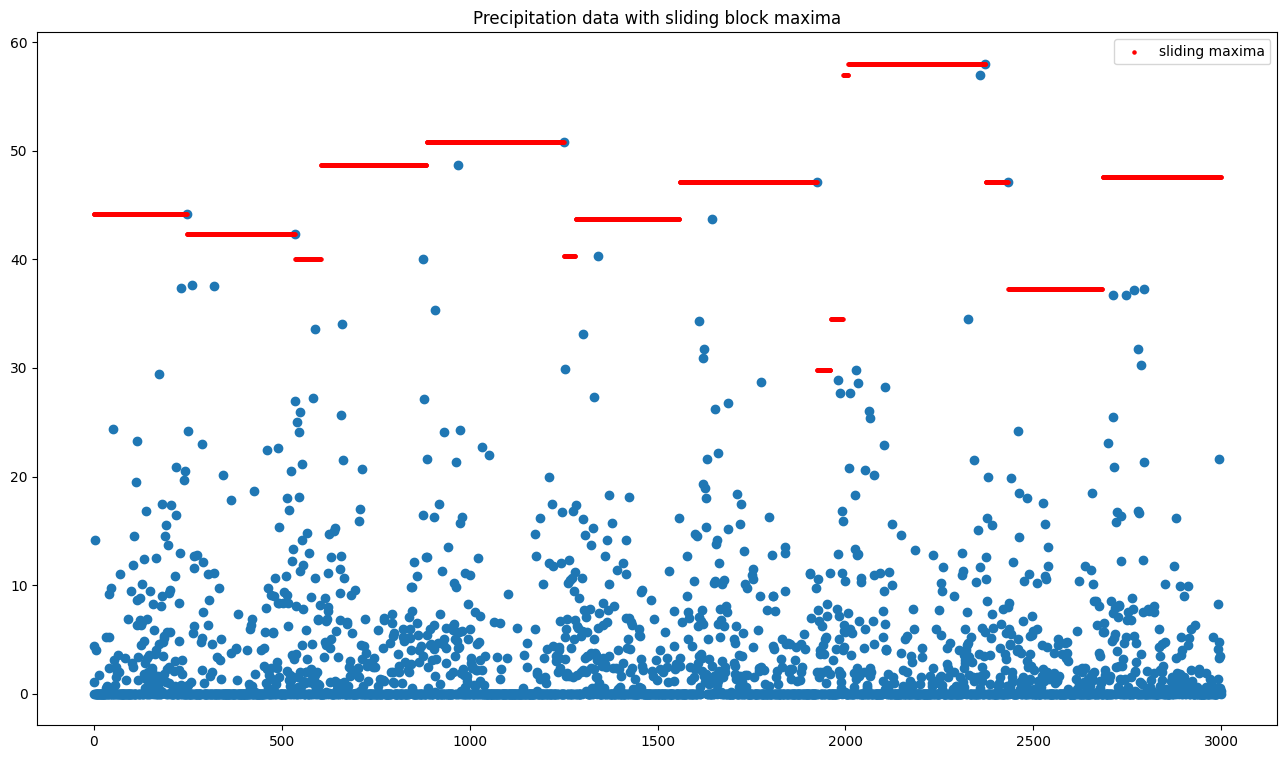

In [63]:
fig = plt.figure(figsize=(16,9))
plt.tight_layout()
plt.title(f'Precipitation data with sliding block maxima')
plt.scatter(np.arange(len(precip[:plotlim*10])), precip[:plotlim*10])
plt.scatter(np.arange(len(PREC_sl.blockmaxima[:plotlim*10])), PREC_sl.blockmaxima[:plotlim*10], c='r',s=5, label='sliding maxima')
plt.legend()
plt.show()

## Vizualize the goodness of fits

<div style="background-color: #ffcccc; padding: 10px; border-radius: 5px;">
    <p> Task: Create an histogram containing the blockmaxima and plot the estimated densities on top.
    <p> Hint: Use `xx.miscellaneous.GEV_pdf`, and, 
    <p> Hint 2: for the Frechet case, use the parameter conversion `g,m,s = 1/frech_param[0], frech_param[1], frech_param[1]/frech_param[0]`
</div>

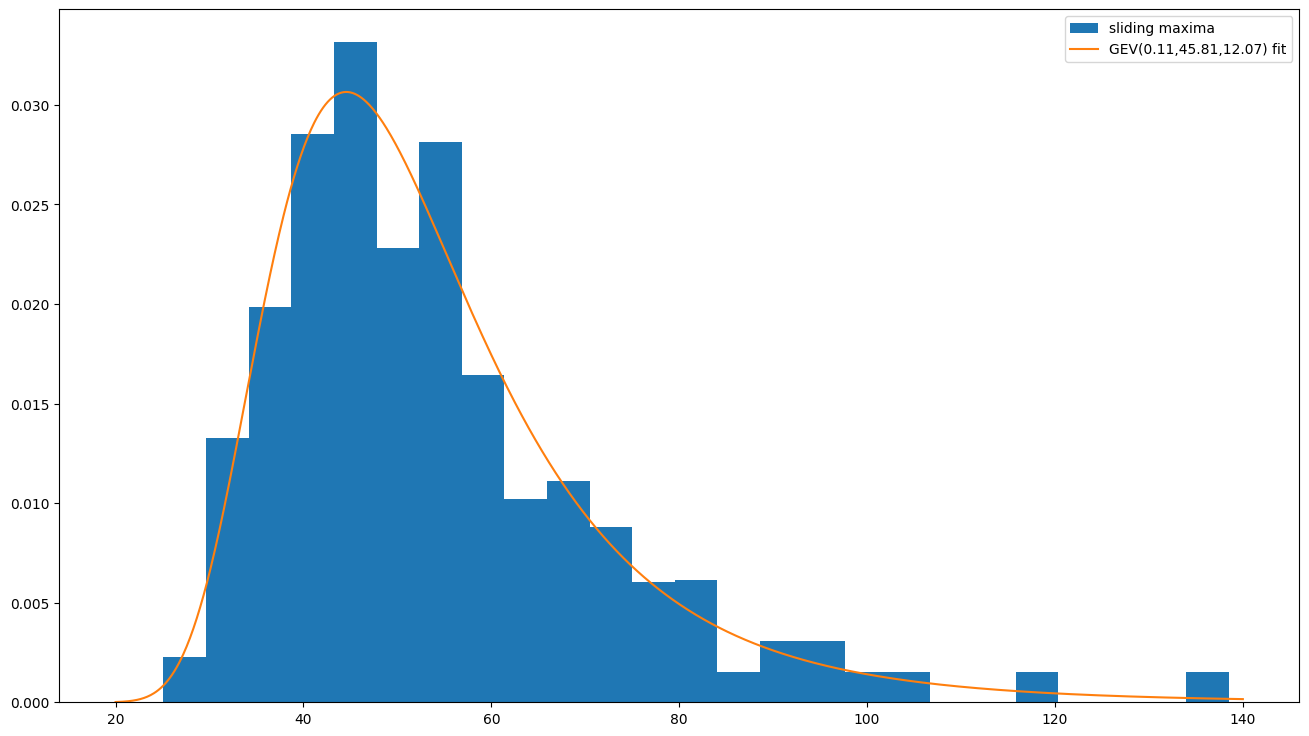

In [59]:
fig = plt.figure(figsize=(16,9))
plt.hist(PREC_sl.blockmaxima,bins=25,density=True,label='sliding maxima')
x = np.linspace(20,140,1000)
g,m,s = PREC_sl.ML_estimators.values
plt.plot(x,xx.miscellaneous.GEV_pdf(x, g,m,s),label=f'GEV({g:.2f},{m:.2f},{s:.2f}) fit')
plt.legend()
plt.show()

# Access the Parameter Uncertainty 
Finally, we demonstrate the usage of a Bootstrap device based on sliding blocks. 

In [66]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")
warnings.filterwarnings("ignore", message="invalid value encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in power")

In [67]:
FB = bst.FullBootstrap(precip,bs=365,stride='DBM',dist_type='GEV')
FB.run_bootstrap(num_bootstraps=1000,max_workers=10)
FB.statistics

100%|██████████| 1000/1000 [00:19<00:00, 51.72it/s]


{'mean': array([ 0.11490562, 45.85663615, 11.9005439 ]),
 'std': array([0.06651365, 1.39574532, 1.77239303])}

In [68]:
# confidence interval
FB.get_CI(method='bootstrap', alpha=0.05)
FB.CI

array([[2.30510258e-02, 2.37985759e-01],
       [4.29815645e+01, 4.86257313e+01],
       [9.93808117e+00, 1.36957872e+01]])

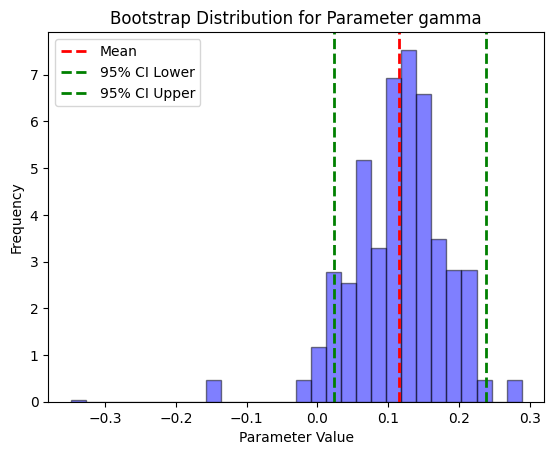

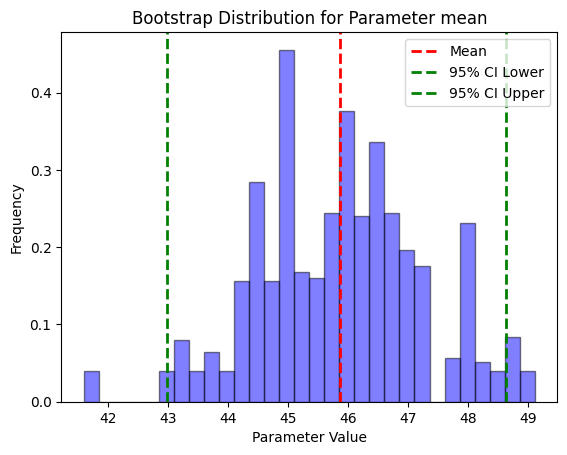

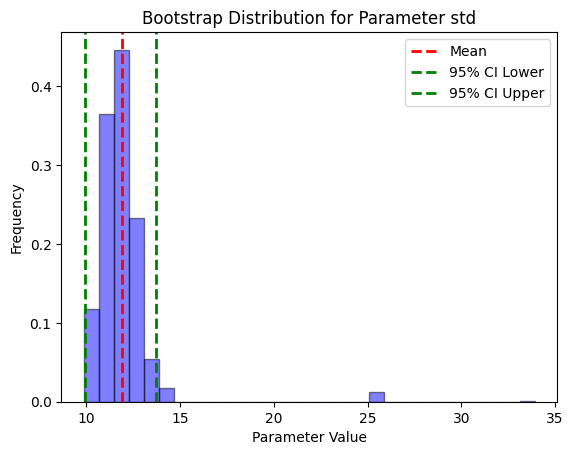

In [69]:
FB.plot_bootstrap(param_idx=0, param_name='gamma')
FB.plot_bootstrap(param_idx=1, param_name='mean')
FB.plot_bootstrap(param_idx=2, param_name='std')